In [1]:
import xarray as xr
import csv
import pandas as pd
import numpy as np
import os
import pickle as pkl
from datetime import datetime, date, timedelta
import sys
import matplotlib.pyplot as plt
import scipy.io as scipy
import netCDF4 as nc
import glob
from matplotlib.pyplot import figure
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
from numpy import trapz
import pickle
from scipy.stats import sem
from FUNCTIONS_HYCOM import set_regions, set_regions_tags, find_timedelta64_index

In [2]:
timesteps_before = 2*8
timesteps_after = 21*8
conversion_factor_3hourly = 3/24
# Create datetime vector for plot (every 3 hours, from -7 to +7 days)
time_plot = np.arange(-timesteps_before,timesteps_after+1,1)*conversion_factor_3hourly # move conversion factor (3/24)
years = ['2011', '2012', '2013', '2014', '2015']
start_year = 2011 # 2009
end_year = 2015 # 2018
plotting_tag = False

In [5]:
# List all the regions

# lat_max, lat_min, lon_max, lon_min for every region
# UNCOMMENT
regions = set_regions()
regions_tags = set_regions_tags(regions)


# ADDED JUST FOR CREATING WIND AND PRECIPITATION FILES
# regions_tags = ['WPacific_1of3']
print(regions_tags)


['WPacific_1of3', 'EPacific', 'NorthAtlantic', 'Indian', 'SWPacific_1of2', 'SWPacific_2of2', 'WPacific_2of3', 'WPacific_3of3']


In [6]:
main_dir = '/Users/jacoposala/Desktop/CU/3.RESEARCH/ARGO_analysis/TC_HYCOM/'
forcing_dir = main_dir + 'DATA/FORCING_alltimes_singleevents/'

In [7]:
dirs_plots = ['abs', 'abs_minus2']
dirs_plots_cmap = ['viridis', 'RdBu_r']
vars_plots = ['salinity', 'temperature', 'density']
flag_xaxis_label_all = [False, False, True]

In [8]:
def plot_single_events(fig_handle, ax_handle, xr_D, var_name, var_name_MLD, xaxis, ylim=(0,150), \
                       flag_xaxis_label=True, cmap='viridis', norm_flag = True):
    fontsize = 18
    if norm_flag:
        norm = mcolors.TwoSlopeNorm(vmin=xr_D[var_name].values.transpose().min(), vmax = xr_D[var_name].values.transpose().max(), vcenter=0)
        im = ax_handle.pcolor(xaxis, xr_D.depth.values, xr_D[var_name].values.transpose(), cmap=cmap, norm=norm)
    else: 
        im = ax_handle.pcolor(xaxis, xr_D.depth.values, xr_D[var_name].values.transpose(), cmap=cmap)
    ax_handle.plot(xaxis, xr_D[var_name_MLD].values, 'k')
    ax_handle.set_ylabel('Depth (m)', fontsize = fontsize)
    ax_handle.axvline(0, c = 'k')
    if flag_xaxis_label:
        ax_handle.set_xlabel('Days from event', fontsize = fontsize)
    ax_handle.set_ylim(ylim) # select the first 200 meters
    divider = make_axes_locatable(ax_handle)
    cax = divider.append_axes('right', size='2%', pad=0.05)
    fig_handle.colorbar(im, cax=cax, orientation='vertical')
    cax.tick_params(labelsize=14)
    ax_handle.invert_yaxis()
    ax_handle.set_title(var_name, fontsize = fontsize)
    ax_handle.xaxis.get_label().set_fontsize(fontsize)
    ax_handle.yaxis.get_label().set_fontsize(fontsize)
    ax_handle.tick_params(axis='y', labelsize=fontsize)
    ax_handle.tick_params(axis='x', labelsize=fontsize)



In [9]:
def plot_single_events_forcing(fig_handle, ax_handle, df_forcing, time_event):
    fontsize = 18
    ax_handle.plot(df_forcing["DATETIME"], df_forcing["WIND"], 'k', linewidth = 3, label = 'Wind speed [m/s]')
    ax_handle2 = ax_handle.twinx()
    ax_handle2.plot(df_forcing["DATETIME"], df_forcing["PRECIPITATION"], 'b', linewidth = 3, label = 'Precipitation [mm/h]')
    ax_handle2.plot([time_event, time_event], ax_handle.get_ylim(), linestyle = '-', c = 'k')
    ax_handle2.set_xlim([min(df_forcing["DATETIME"]), max(df_forcing["DATETIME"])])
    ax_handle.xaxis.get_label().set_fontsize(fontsize)
    ax_handle.yaxis.get_label().set_fontsize(fontsize)
    ax_handle.tick_params(axis='x', labelsize=fontsize)
    ax_handle.tick_params(axis='y', labelsize=fontsize)
    ax_handle2.xaxis.get_label().set_fontsize(fontsize)
    ax_handle2.yaxis.get_label().set_fontsize(fontsize)
    ax_handle2.tick_params(axis='x', labelsize=fontsize)
    ax_handle2.tick_params(axis='y', labelsize=fontsize)
    h1, l1 = ax_handle.get_legend_handles_labels()
    h2, l2 = ax_handle2.get_legend_handles_labels()
    ax_handle.legend(h1+h2, l1+l2, loc=1)
    

In [10]:
def open_forcing(forcing_name, forcing_dir, start_year, end_year):
    df_forcing = pd.read_csv(forcing_dir + forcing_name)
#     print(forcing_name)

    # Convert lon from [0,360] to [-180,180]
    df_forcing.lon = (df_forcing.lon + 180) % 360 - 180

    # Rename columns to match old version
    df_forcing.rename(columns={'lat': 'LAT', 'lon': 'LONG', 'wind_speed': 'WIND', 'time': 'DATETIME', 'precipitation': 'PRECIPITATION'}, inplace=True)

    # create mask based on start_year
    dfs_mask_1 = pd.to_datetime(df_forcing.DATETIME).dt.year>=start_year
    # apply mask start_year to df
    dfs_1 = df_forcing[dfs_mask_1].reset_index()

    # create mask based on end_year
    dfs_mask_2 = pd.to_datetime(dfs_1.DATETIME).dt.year<=end_year
    # apply mask end_year to df
    dfs_select = dfs_1[dfs_mask_2].reset_index()
    dfs_select.shape
    dfs_select['DATETIME'] = pd.to_datetime(dfs_select['DATETIME'])
    return(dfs_select)


In [145]:
# Save precipitation and wind data from forcing for Donata

timesteps_before = 2*8 # 6*8 
timesteps_after = 14*8 # 6*8

len_time = len(np.arange(-timesteps_before,timesteps_after+1,1))

# Create empty arrays for wind and precipitation
wind_all = np.empty([len_time,])
precipitation_all = np.empty([len_time,])

for r_tag in regions_tags:
    
    HYCOM_dir  = main_dir + 'DATA/6_HYCOM_near_TC_53x_pkl_NEW_BOX_postproc_' + r_tag + '/'
    HYCOM_save_dir = main_dir + 'PLOTS_single_events/'
    files_in_dir = [j for j in sorted(glob.glob(HYCOM_dir + '*.pkl'))]
        
    for ifile in files_in_dir: 
        
        # Open HYCOM event data
        new_dict_original = pkl.load(open(ifile, "rb"))
        
        ind_fix = find_timedelta64_index(np_array_timedelta64 = new_dict_original.time.values[1:]-new_dict_original.time.values[0:-1],\
                          np_timedelta64_sel_ns = np.timedelta64(0, 'ns') # nanoseconds
                                    )[0]+1
        if len(ind_fix) > 0:
            for ifix in ind_fix:
                new_dict_original.delta_time_approx.values[ifix] = np.timedelta64(1, 'ns')

        ind = find_timedelta64_index(np_array_timedelta64 = new_dict_original.delta_time_approx.values,\
                          np_timedelta64_sel_ns = np.timedelta64(0, 'ns') # nanoseconds
                          )[0] 
        if len(ind)>1:
            ciao

        new_dict = new_dict_original.isel(time=np.arange(ind-timesteps_before,ind+timesteps_after+1,1))        
        
        # Load full forcing time series for this event
        sel_lat = new_dict.latitude.values
        sel_lon_360 = new_dict.longitude.values % 360
        
        bfr_all = open_forcing(forcing_name='df_forcing_' + str(sel_lat) + '_' + str(sel_lon_360) + '_' + years[0] + '_' + r_tag + '.csv', \
                               forcing_dir=forcing_dir, start_year=start_year, end_year=end_year)
        
        for y in years[1:]:
            bfr_temp = open_forcing(forcing_name='df_forcing_' + str(sel_lat) + '_' + str(sel_lon_360) + '_' + y + '_' + r_tag + '.csv', \
                                    forcing_dir=forcing_dir, start_year=start_year, end_year=end_year)
            
            bfr_all = pd.concat([bfr_all,bfr_temp])

        # Down-select forcing to have one data point every 3 hours to match the time period of the HYCOM event
        forcing_sel = pd.merge_asof(new_dict_df, bfr_all, on="DATETIME", tolerance=pd.Timedelta("29min"))
            
        # Stack wind and precipitation arrays for Donata, using the same len_time convention used in script #8
        wind_all = np.vstack((wind_all, forcing_sel.WIND.values[0:len_time]))
        precipitation_all = np.vstack((precipitation_all, forcing_sel.PRECIPITATION.values[0:len_time]))

# Save as .mat files
scipy.savemat('wind_all.mat', {'wind_all': wind_all[1:,:]})
scipy.savemat('precipitation_all.mat', {'precipitation_all': precipitation_all[1:,:]})        


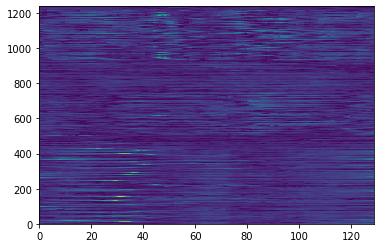

In [157]:
plt.pcolor(wind_all[1:,:])

In [148]:
wind_all[1:,:]

array([[11.47070312, 10.60449219, 11.2890625 , ..., 11.09570312,
        12.81152344, 13.75      ],
       [ 4.91113281,  5.21875   ,  5.80859375, ...,  4.09082031,
         4.69628906,  4.921875  ],
       [36.79003906, 31.53710938, 24.57617188, ..., 13.29199219,
        13.79394531, 14.51464844],
       ...,
       [ 6.97460938,  7.54199219,  7.32421875, ...,  5.18261719,
         4.83398438,  4.87402344],
       [ 6.07226562,  6.30371094,  6.8125    , ...,  4.96484375,
         6.38769531,  7.2734375 ],
       [ 6.21972656,  6.56445312,  6.71289062, ...,  3.33789062,
         4.03320312,  3.82324219]])

In [11]:
# Create empty arrays for wind and precipitation
wind_all = np.array([])
precipitation_all = np.array([])

for r_tag in regions_tags:
    
    HYCOM_dir  = main_dir + 'DATA/6_HYCOM_near_TC_53x_pkl_NEW_BOX_postproc_' + r_tag + '/'
    HYCOM_save_dir = main_dir + 'PLOTS_single_events/'
    files_in_dir = [j for j in sorted(glob.glob(HYCOM_dir + '*.pkl'))]
        
    for ifile in files_in_dir:
        new_xr_D_original = pkl.load(open(ifile, "rb"))
        ind_fix = find_timedelta64_index(np_array_timedelta64 = new_xr_D_original.time.values[1:]- \
                                         new_xr_D_original.time.values[0:-1],\
                          np_timedelta64_sel_ns = np.timedelta64(0, 'ns') # nanoseconds
                                    )[0]+1
        if len(ind_fix) > 0:
            for ifix in ind_fix:
                new_xr_D_original.delta_time_approx.values[ifix] = np.timedelta64(1, 'ns')

        ind = find_timedelta64_index(np_array_timedelta64 = new_xr_D_original.delta_time_approx.values,\
                          np_timedelta64_sel_ns = np.timedelta64(0, 'ns') # nanoseconds
                          )[0] 
        if len(ind)>1:
            ciao
            
        new_xr_D = new_xr_D_original.isel(time=np.arange(ind-timesteps_before,ind+timesteps_after+1,1))
        
        
        sel_lat = new_xr_D.latitude.values
        sel_lon_360 = new_xr_D.longitude.values % 360
        
        bfr_all = open_forcing(forcing_name='df_forcing_' + str(sel_lat) + '_' + str(sel_lon_360) + '_' + years[0] + '_' + r_tag + '.csv', \
                               forcing_dir=forcing_dir, start_year=start_year, end_year=end_year)
        
        for y in years[1:]:
            bfr_temp = open_forcing(forcing_name='df_forcing_' + str(sel_lat) + '_' + str(sel_lon_360) + '_' + y + '_' + r_tag + '.csv', \
                                    forcing_dir=forcing_dir, start_year=start_year, end_year=end_year)
            
            bfr_all = pd.concat([bfr_all,bfr_temp])
        
        new_df_forcing = bfr_all.loc[(bfr_all['DATETIME'] >= new_xr_D.time.values[0]) & \
                                  (bfr_all['DATETIME'] <= new_xr_D.time.values[-1])]
        new_df_forcing = new_df_forcing.reset_index(drop=True)
        

        if plotting_tag:
            for j in np.arange(0,len(dirs_plots),1):
                f, (a0, a1, a2, a3) = plt.subplots(4, 1, figsize = (12,12), gridspec_kw={'height_ratios': [1, 2, 2, 2]})
    #             print(j)
                plot_single_events_forcing(fig_handle = f, ax_handle = a0, df_forcing = new_df_forcing, \
                                           time_event = datetime.strptime(str(new_xr_D.sel_date.values), '%Y-%m-%d %H:%M:%S'))
                if 'minus2' in dirs_plots[j]:
                    norm_flag_bfr=True
                else:
                    norm_flag_bfr=False
                f.subplots_adjust(hspace=0.4)

                for i in np.arange(0,len(vars_plots),1):
                    plot_single_events(fig_handle = f, ax_handle = eval('a' + str(i+1)), xr_D = new_xr_D, \
                                       var_name = vars_plots[i] + '_' + dirs_plots[j], xaxis = time_plot, ylim=(0,150), \
                                       flag_xaxis_label = flag_xaxis_label_all[i], var_name_MLD = 'salinityMLD_abs', \
                                       cmap = dirs_plots_cmap[j], \
                                       norm_flag=norm_flag_bfr)
    #             plt.show()

                f.tight_layout()
                f.savefig(HYCOM_save_dir + ifile[109:-4] + '_' + str(dirs_plots[j]) + '.png', dpi = 300)
                plt.close("all")
    # Append wind and precipitation arrays for Donata
    wind_all = np.append(wind_all, new_df_forcing.WIND.values)
    precipitation_all = np.append(precipitation_all, new_df_forcing.PRECIPITATION.values)

    scipy.savemat('wind_all.mat', {'wind_all': wind_all})
    scipy.savemat('precipitation_all.mat', {'precipitation_all': precipitation_all})       


KeyboardInterrupt: 

In [ ]:
prova = scipy.loadmat('wind_all.mat')


In [ ]:
ciao = prova["wind_all"]

In [ ]:
len(ciao[0][:])

In [12]:
new_df_forcing.WIND

0       2.135742
1       1.526367
2       1.188477
3       0.525391
4       0.555664
         ...    
548    10.702148
549     9.230469
550     8.071289
551     7.812500
552     8.463867
Name: WIND, Length: 553, dtype: float64